In [34]:
from framework.simulation.faradaysource import FaradayThinSource,FaradayThickSource
from framework.reconstruction.parameter import Parameter
import numpy as np
from IPython.display import clear_output
from framework.io.io_functions import Reader, Writer
from framework.base.dataset import Dataset
from framework.transformers.dfts import DFT1D, NUFFT1D
import matplotlib.pyplot as plt
from framework.objectivefunction.ofunction import OFunction
from framework.utils.utilities import real_to_complex, complex_to_real, find_pixel
from framework.objectivefunction.priors import TSV, TV, L1, Chi2
from framework.optimization.optimizer import FISTA, ADMM, SDMM, GradientBasedMethod
from framework.utils.analytical_functions import Gaussian
from framework.transformers.gridding import Gridding
from scipy.constants import c
from pynufft import NUFFT
from scipy import signal as sci_signal
import itertools

In [35]:
np.random.seed(666)

In [36]:
nu = np.linspace(start=1.008e9, stop=2.031e9, num=1000)

In [37]:
peak_thinsource = 0.0035
peak_thicksource = 0.0035

In [38]:
thinsource = FaradayThinSource(nu=nu, s_nu=peak_thinsource, phi_gal=-200, spectral_idx=1.0)

In [39]:
thicksource = FaradayThickSource(nu=nu, s_nu=peak_thicksource, phi_fg=100, phi_center=200, spectral_idx=1.0)

In [40]:
thinsource.simulate()
thicksource.simulate()

In [41]:
simsource = thinsource #thicksource

In [42]:
simsource.remove_channels(0.4)

In [43]:
simsource.apply_noise(peak_thinsource/10)

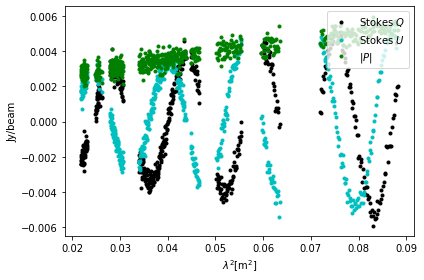

In [44]:
plt.plot(simsource.lambda2, simsource.data.real, 'k.', label=r"Stokes $Q$")
plt.plot(simsource.lambda2, simsource.data.imag, 'c.', label=r"Stokes $U$")
plt.plot(simsource.lambda2, np.abs(simsource.data), 'g.', label=r"$|P|$")
plt.xlabel(r'$\lambda^2$[m$^{2}$]')
plt.ylabel(r'Jy/beam')
plt.legend(loc='upper right')
plt.tight_layout()

In [45]:
dataset = simsource

In [46]:
parameter = Parameter()

In [47]:
parameter.calculate_cellsize(dataset=dataset)

FWHM of the main peak of the RMTF: 52.102 rad/m^2
Maximum recovered width structure: 144.188 rad/m^2
Maximum Faraday Depth to which one has more than 50% sensitivity: 15604.548


In [48]:
nufft = NUFFT1D(dataset=dataset, parameter=parameter, solve=True)

In [49]:
dft = DFT1D(dataset=dataset, parameter=parameter)

In [50]:
F_dirty = dft.backward(dataset.data)

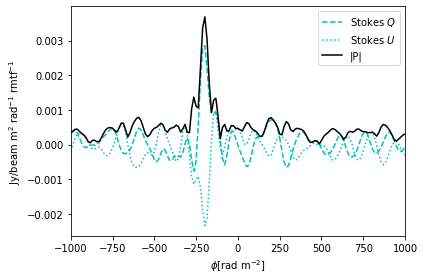

In [51]:
plt.plot(parameter.phi, F_dirty.real, 'c--', label=r"Stokes $Q$")
plt.plot(parameter.phi, F_dirty.imag, 'c:', label=r"Stokes $U$")
plt.plot(parameter.phi, np.abs(F_dirty), 'k-', label=r"|P|")
plt.xlabel(r'$\phi$[rad m$^{-2}$]')
plt.ylabel(r'Jy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
plt.legend(loc='upper right')
plt.xlim([-1000,1000])
plt.tight_layout()

In [52]:
idx_noise = np.where(np.abs(parameter.phi)>10000)
noise_F = np.std(0.5*(F_dirty[idx_noise].real + F_dirty[idx_noise].imag))
noise_F

1.7249844e-05

In [53]:
F_back = nufft.backward(dataset.data)

(-1000.0, 1000.0)

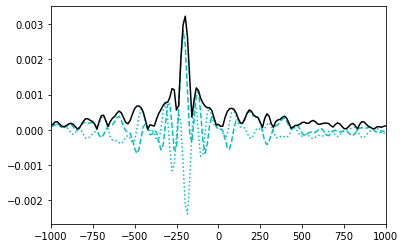

In [54]:
plt.plot(parameter.phi, F_back.real, 'c--', label=r"Real part")
plt.plot(parameter.phi, F_back.imag, 'c:', label=r"Imaginary part")
plt.plot(parameter.phi, np.abs(F_back), 'k-', label=r"Amplitude")
plt.xlim([-1000,1000])

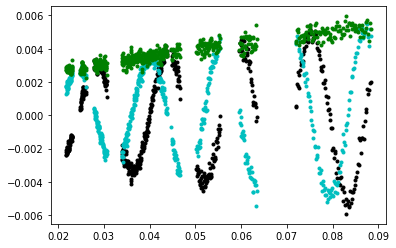

In [55]:
P_back = nufft.forward_normalized(F_back)
plt.plot(dataset.lambda2, P_back.real, 'k.', label=r"Stokes $Q$")
plt.plot(dataset.lambda2, P_back.imag, 'c.', label=r"Stokes $U$")
plt.plot(dataset.lambda2, np.abs(P_back), 'g.', label=r"$|P|$")

In [56]:
lambda_l1 = np.sqrt(2.0 * dataset.m + 4.0 * np.sqrt(dataset.m))*noise_F
#lambda_l1 /= 10
#lambda_l1=0.5
lambda_tsv = 0.0
chi2 = Chi2(dft_obj=nufft)
l1 = L1(reg=lambda_l1)
tsv = TSV(reg=lambda_tsv)
# F_func = [chi2(P, dft, W), L1(lambda_l1)]
F_func = [chi2, l1, tsv]
f_func = [chi2]
g_func = [l1, tsv]

F_obj = OFunction(F_func)
f_obj = OFunction(f_func)
g_obj = OFunction(g_func)

In [57]:
parameter.data = F_back

In [58]:
parameter.complex_data_to_real()

In [59]:
opt = FISTA(guess_param=parameter, F_obj=F_obj, fx=chi2, gx=g_obj, noise=noise_F, verbose=True)
#opt = FISTA(i_guess=F_real, F_obj=F_obj, fx=chi2, gx=g_obj, maxiter=1000, noise=1e-5, verbose=True)
obj, X = opt.run()

Iterations set to 36
Iteration:  0  objective function value: 0.00154


In [60]:
X.real_data_to_complex()

(-1000.0, 1000.0)

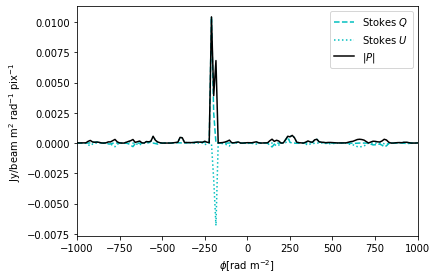

In [61]:
plt.plot(parameter.phi, X.data.real, 'c--', label=r"Stokes $Q$")
plt.plot(parameter.phi, X.data.imag, 'c:', label=r"Stokes $U$")
plt.plot(parameter.phi, np.abs(X.data), 'k-', label=r"$|P|$")
plt.xlabel(r'$\phi$[rad m$^{-2}$]')
plt.ylabel(r'Jy/beam m$^2$ rad$^{-1}$ pix$^{-1}$')
plt.legend(loc='upper right')
plt.tight_layout()
plt.xlim([-1000,1000])

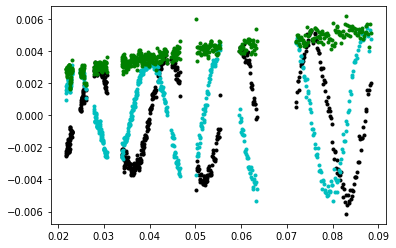

In [62]:
plt.plot(dataset.lambda2, dataset.model_data.real, 'k.', label=r"Stokes $Q$")
plt.plot(dataset.lambda2, dataset.model_data.imag, 'c.', label=r"Stokes $U$")
plt.plot(dataset.lambda2, np.abs(dataset.model_data), 'g.', label=r"$|P|$")

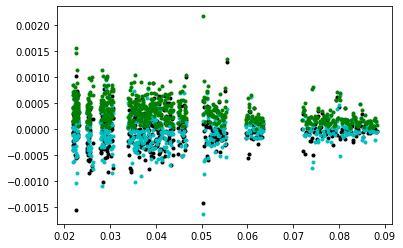

In [63]:
plt.plot(dataset.lambda2, dataset.residual.real, 'k.', label=r"Stokes $Q$")
plt.plot(dataset.lambda2, dataset.residual.imag, 'c.', label=r"Stokes $U$")
plt.plot(dataset.lambda2, np.abs(dataset.residual), 'g.', label=r"$|P|$")

In [64]:
F_residual = nufft.backward(dataset.residual)

In [65]:
conv_model = X.convolve() + F_residual

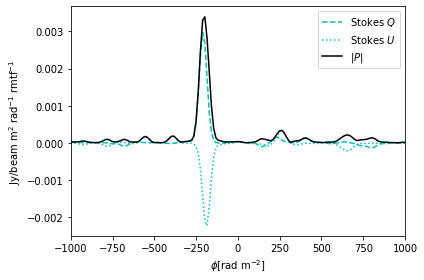

In [66]:
plt.plot(parameter.phi, conv_model.real, 'c--', label=r"Stokes $Q$")
plt.plot(parameter.phi, conv_model.imag, 'c:', label=r"Stokes $U$")
plt.plot(parameter.phi, np.abs(conv_model), 'k-', label=r"$|P|$")
plt.xlim([-1000,1000])
plt.xlabel(r'$\phi$[rad m$^{-2}$]')
plt.ylabel(r'Jy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig("restored.png", dpi=100)